| Name | Surname | ID Number |
|------|---------|---------------------|
| Lorenzo | Calandra Buonaura | 2107761 |

In [8]:
library("ggplot2", warn.conflicts = FALSE, quietly = TRUE)
library("spatstat", warn.conflicts = FALSE, quietly = TRUE)
library("Hmisc", warn.conflicts = FALSE, quietly = TRUE)
library("cmdstanr")

spatstat.geom 3.2-9

spatstat.random 3.2-3

spatstat.explore 3.2-7

spatstat.model 3.2-11

spatstat.linnet 3.1-5


spatstat 3.0-8 
For an introduction to spatstat, type ‘beginner’ 




# Exercise 1

Ladislaus Josephovich Bortkiewicz was a Russian economist and statistician. He noted that the Poisson distribution can be very useful in applied statistics when describing low-frequency events in a large population. In a famous example he showed that the number of deaths by horse kick among the Prussian army follows the Poisson distribution.

Considering the following two sets of observations taken over a fixed large time interval in two different corps:

| y - death soldiers |  0  | 1  | 2  | 3  | 4 | ≥5 |
|--------------------|-----|----|----|----|---|----|
| n1 - observations  | 109 | 65 | 22 | 3  | 1 | 0  |
| n2 - observations  | 144 | 91 | 32 | 11 | 2 | 0  |

(a) assuming a uniform prior, compute and plot the posterior distribution for $\lambda$, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval.

In [9]:
c_int <- function(val, int, param) {
  low <- 0
  up <- 0
  a <- 1
  b <- 1

  limits <- c((1 - int) / 2, (1 + int) / 2)

  while (low < limits[1]) {
    low <- low + val[a]
    a <- a + 1
  }

  while (up < limits[2]) {
    up <- up + val[b]
    b <- b + 1
  }

  if (b > length(param)) {
    b <- length(param)
  }

  return(c(param[a], param[b]))
}

In [10]:
y <- c(0, 1, 2, 3, 4, ">=5")
n1 <- c(109, 65, 22, 3, 1, 0)
n2 <- c(144, 91, 32, 11, 2, 0)

combined_obs <- n1 + n2

total_counts <- sum(combined_obs)
total_deaths <- sum(c(0, 1, 2, 3, 4, 5) * combined_obs)

Mean: 0.6645833 
Median: 0.6635 
Variance: 0.001395138 
95% Credibility Interval: ( 0.595 , 0.74 )


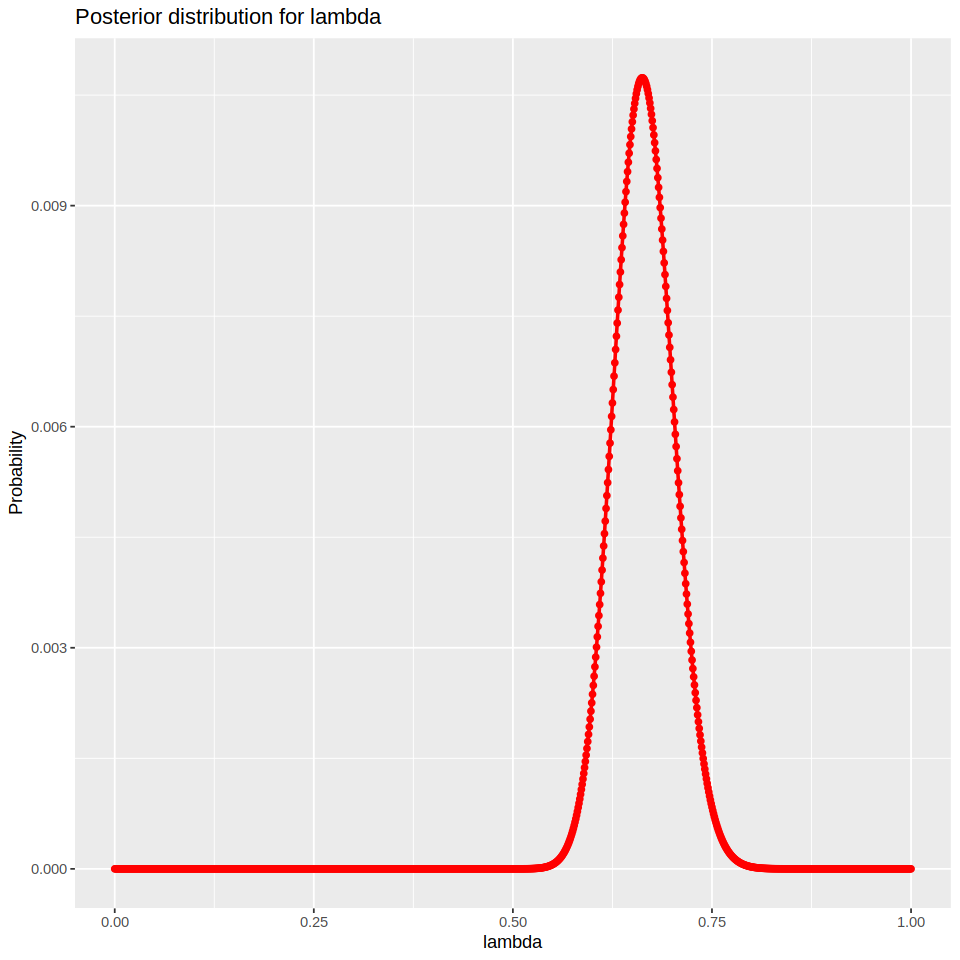

In [11]:
lambda <- seq(0, 1, 0.001)
post_values <- dgamma(lambda, shape = total_deaths + 1, rate = total_counts)
post_values <- post_values / sum(post_values)

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(data = data.frame(lambda, post_values),
       aes(x = lambda, y = post_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for lambda",
       x = "lambda",
       y = "Probability")

lambda_mean <- weighted.mean(lambda, post_values)
lambda_median <- weighted.median(lambda, post_values)
lambda_variance <- weighted.var(lambda, post_values)

cred_int <- c_int(post_values, 0.95, lambda)

cat("Mean:", lambda_mean, "\n")
cat("Median:", lambda_median, "\n")
cat("Variance:", lambda_variance, "\n")
cat("95% Credibility Interval:", "(", cred_int[1], ",", cred_int[2], ")\n")

(b) assuming now a Jeffreys’ prior, $g(\lambda) \propto \frac{1}{\sqrt{\lambda}}$, with $\lambda > 0$, compute and plot the posterior distribution for λ, the death rate over the measurement time. Determine the posterior mean, median and variance, and compute the 95% credibility interval

Mean: 0.6635417 
Median: 0.6625 
Variance: 0.00139296 
95% Credibility Interval: ( 0.594 , 0.739 )


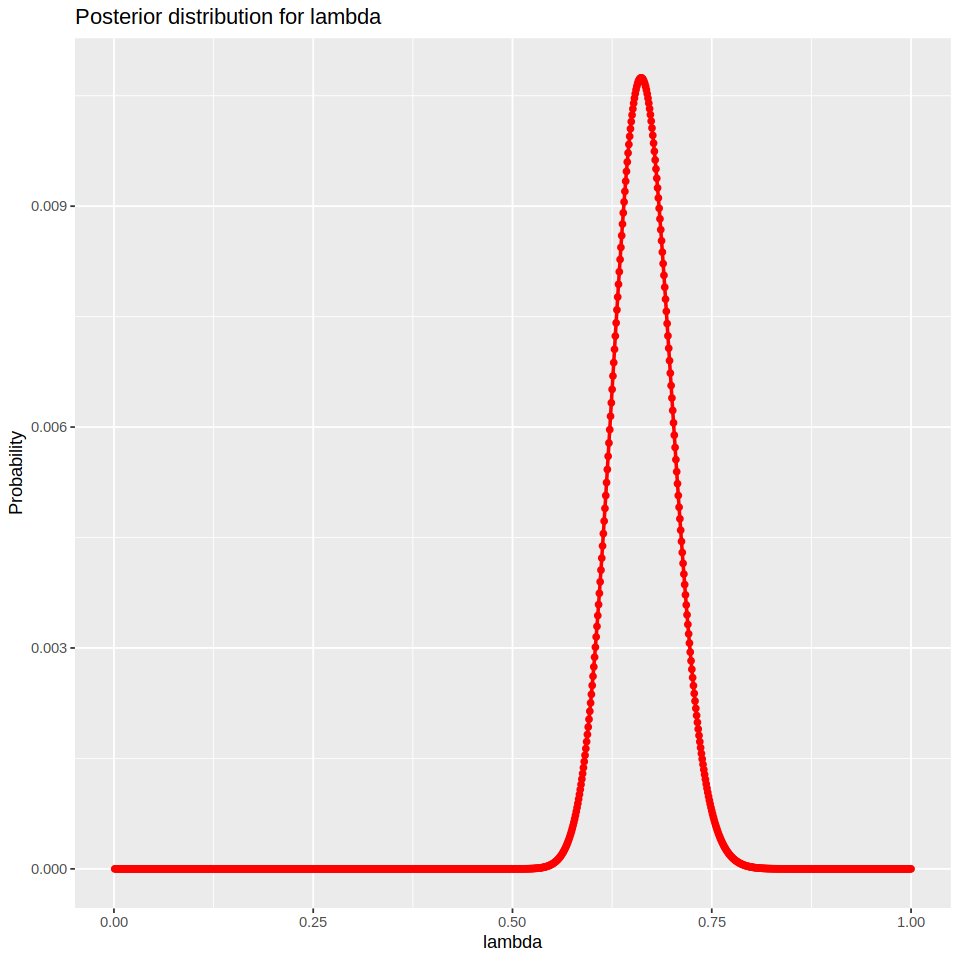

In [12]:
prior <- function(lambda) {
  return(1 / sqrt(lambda))
}

lambda <- seq(0.001, 1, 0.001)
prior_values <- prior(lambda)
post_values <- dgamma(lambda, shape = total_deaths + 1, rate = total_counts)
post_values <- post_values * prior_values / sum(post_values * prior_values)

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(data = data.frame(lambda, post_values),
       aes(x = lambda, y = post_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for lambda",
       x = "lambda",
       y = "Probability")

lambda_mean <- weighted.mean(lambda, post_values)
lambda_median <- weighted.median(lambda, post_values)
lambda_variance <- weighted.var(lambda, post_values)

cred_int <- c_int(post_values, 0.95, lambda)

cat("Mean:", lambda_mean, "\n")
cat("Median:", lambda_median, "\n")
cat("Variance:", lambda_variance, "\n")
cat("95% Credibility Interval:", "(", cred_int[1], ",", cred_int[2], ")\n")

# Exercise 2

Solve Exercise 1 using a Markov Chain Monte Carlo using **stan**.

In [13]:
model_string_uniform <- "data {
  int<lower=0> N;
  array[N] int y;
}
parameters {
  real<lower=0, upper=1> lambda;
}
model {
  lambda ~ beta(1, 1);
  y ~ poisson(lambda);
}"

writeLines(model_string_uniform, "model_string_uniform.stan")

In [14]:
mod <- cmdstan_model("model_string_uniform.stan")

In [15]:
occurrencies <- rep(0:5, combined_obs)
data_list <- list(y = occurrencies, N = length(occurrencies))

In [16]:
fit <- mod$sample(
  data = data_list,
  seed = 123,
  chains = 4,
  parallel_chains = 4,
  refresh = 500,
  iter_warmup = 1000,
  iter_sampling = 1000
)

fit$summary()

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 1 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Ite

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-450.9503155,-450.673000,0.74891490,0.33358500,-452.3832500,-450.4300000,1.000889,1698.756,1778.112
lambda,0.6639973,0.662937,0.03761897,0.03779073,0.6038882,0.7266127,1.000827,1239.759,1604.171


In [17]:
posterior_samples <- fit$draws(variables = "lambda")

lambda_mean <- mean(posterior_samples)
lambda_median <- median(posterior_samples)
lambda_variance <- var(posterior_samples)
cred_interval <- quantile(posterior_samples, probs = c(0.025, 0.975))

cat("Mean:", lambda_mean, "\n")
cat("Median:", lambda_median, "\n")
cat("Variance:", lambda_variance, "\n")
cat("95% Credibility Interval:", cred_interval, "\n")

Mean: 0.6639973 
Median: 0.662937 
Variance: 0.001415187 
95% Credibility Interval: 0.5922939 0.7385467 


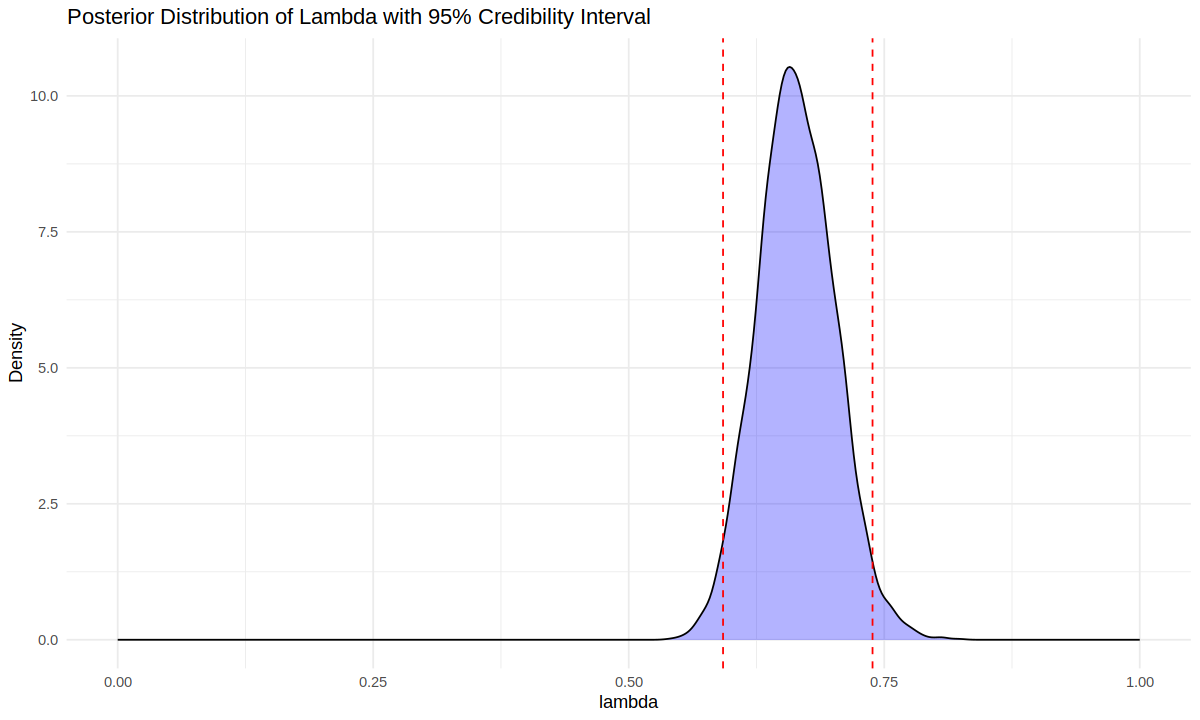

In [18]:
lambda_samples <- as.vector(as.matrix(posterior_samples))

options(repr.plot.width = 10, repr.plot.height = 6)

ggplot(data = data.frame(lambda = lambda_samples), aes(x = lambda)) +
  geom_density(fill = "blue", alpha = 0.3) +
  geom_vline(xintercept = cred_interval[1],
             linetype = "dashed", color = "red") +
  geom_vline(xintercept = cred_interval[2],
             linetype = "dashed", color = "red") +
  labs(title = "Posterior Distribution of Lambda with 95% Credibility Interval",
       x = "lambda",
       y = "Density") +
  xlim(0, 1) +
  theme_minimal()